In [1]:
import numpy as np
import sep

In [2]:
# additional setup for reading the test image and displaying plots
import matplotlib.pyplot as plt
from matplotlib import rcParams

import astropy.io.fits
from astropy.io import fits

%matplotlib inline


rcParams['figure.figsize'] = [10., 8.]

In [3]:
# read image into standard 2-d numpy array
data = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

In [4]:
data = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

In [5]:
# Check byte order and update if necessary
if data.dtype.byteorder not in ('=', '|'):
    data = data.byteswap().newbyteorder()

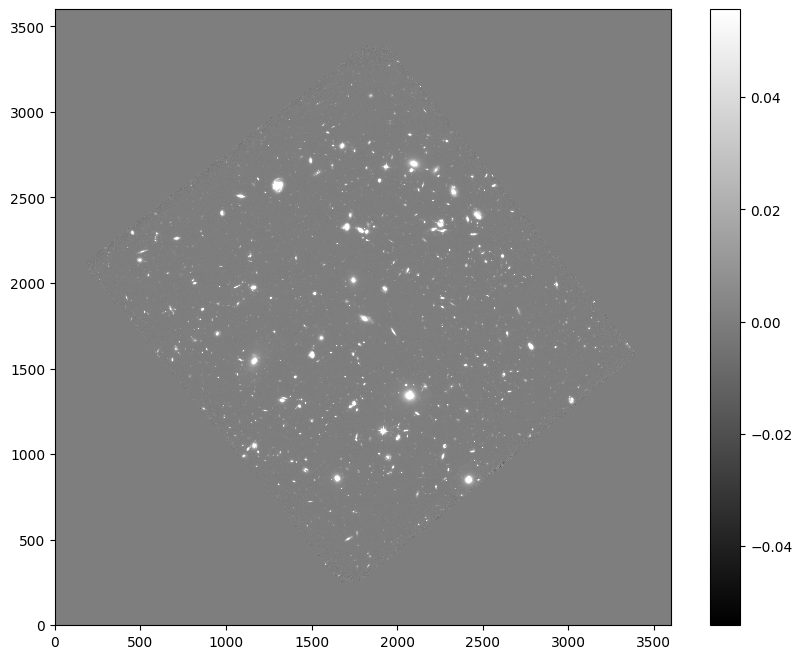

In [6]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("UDF_fits_image.png")

In [7]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

In [8]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [9]:
 # evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

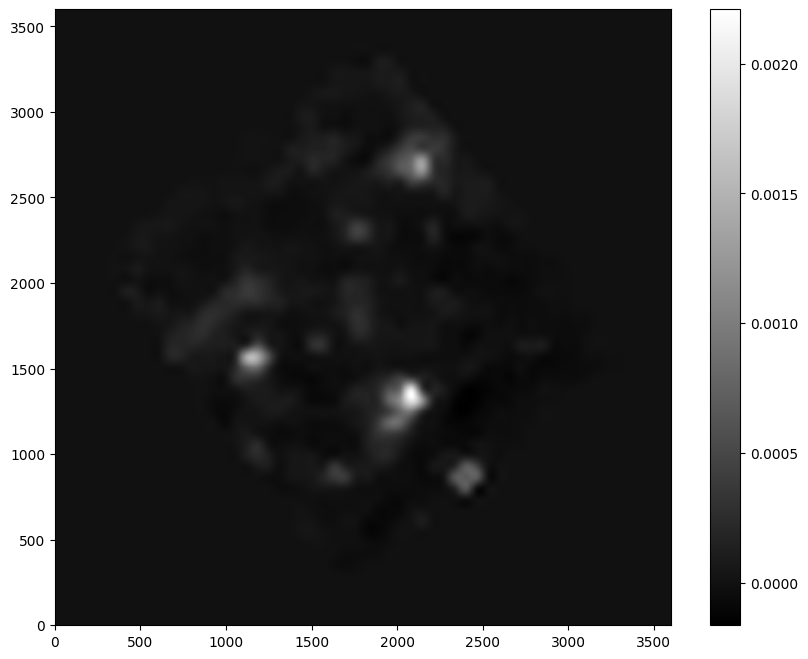

In [10]:
# show the background using 'nearest' interpolation
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("UDF_background_image.png")

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

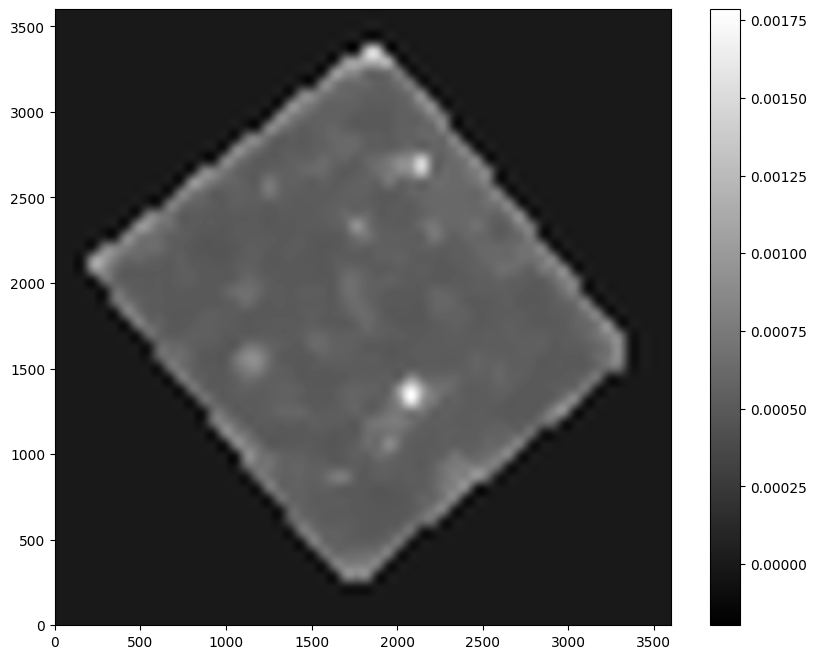

In [12]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('UDF_background_noise.png')

In [13]:
# subtract the background
data_sub = data - bkg

In [14]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [15]:
# how many objects were detected
print("Number of sources detected:", len(objects))

Number of sources detected: 8646


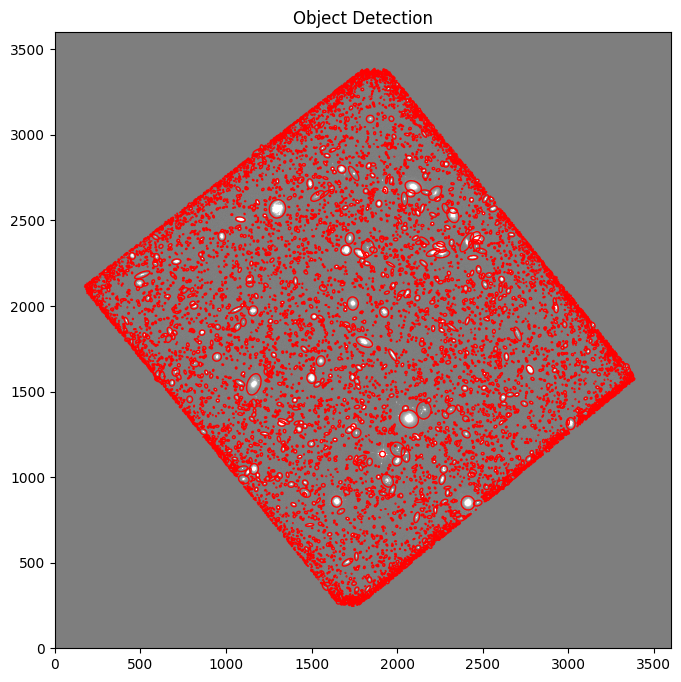

In [23]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.title('Object Detection')
plt.savefig('ellipse_fits.png')

In [17]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

/var/folders/16/_32lgpcd4t5cc4jggm895k7h0000gn/T/ipykernel_14392/2504349481.py:6: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(flux), bins=25, alpha=0.7)


object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


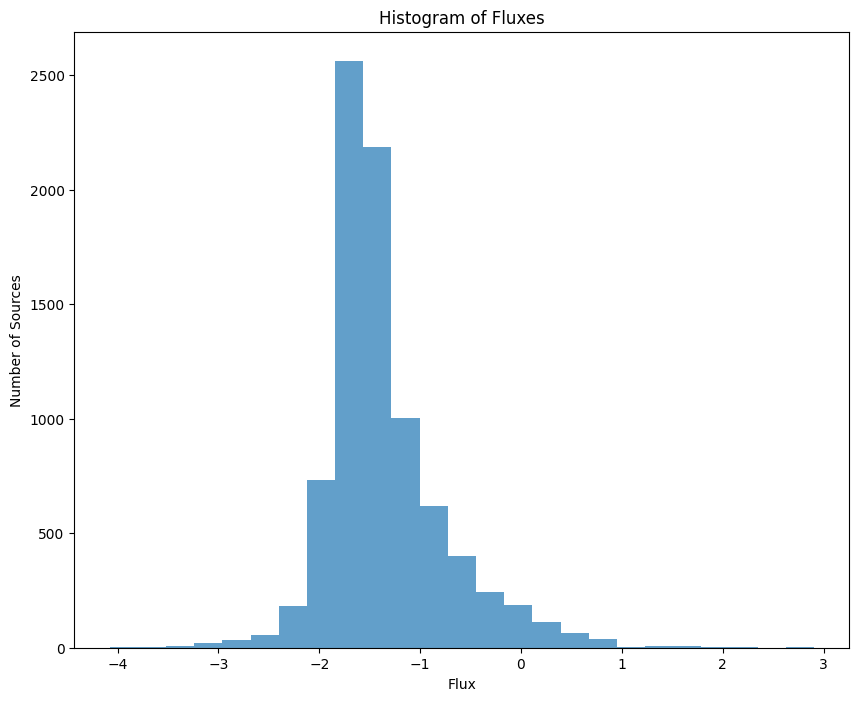

In [18]:
# create a histogram of fluxes
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

# plot the histogram
plt.figure()
plt.hist(np.log10(flux), bins=25, alpha=0.7)
plt.xlabel('Flux')
plt.ylabel('Number of Sources')
plt.title('Histogram of Fluxes')
plt.savefig('flux_histogram.png')

# show the first 10 objects results
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

plt.show()

In [29]:
# Calculate mean, median, and standard deviation of fluxes
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

print("Mean Flux:", mean_flux)
print("Median Flux:", median_flux)
print("Standard Deviation of Flux:", std_flux)

# Finding  largest outlier
outlier_index = np.argmax(flux)
outlier_flux = flux[outlier_index]
outlier_x = objects['x'][outlier_index]
outlier_y = objects['y'][outlier_index]

# Calculate how many standard deviations outlier is away from the mean
std_away = (outlier_flux - mean_flux) / std_flux

print("Largest Outlier Flux:", outlier_flux)
print("Outlier Location (x, y): ({:.2f}, {:.2f})".format(outlier_x, outlier_y))
print("Standard Deviations Away from Mean:", std_away)


Mean Flux: 0.36159539075495284
Median Flux: 0.03097589430617518
Standard Deviation of Flux: 9.24028235192194
Largest Outlier Flux: 807.2972835731507
Outlier Location (x, y): (1914.25, 1134.32)
Standard Deviations Away from Mean: 87.32803365197564


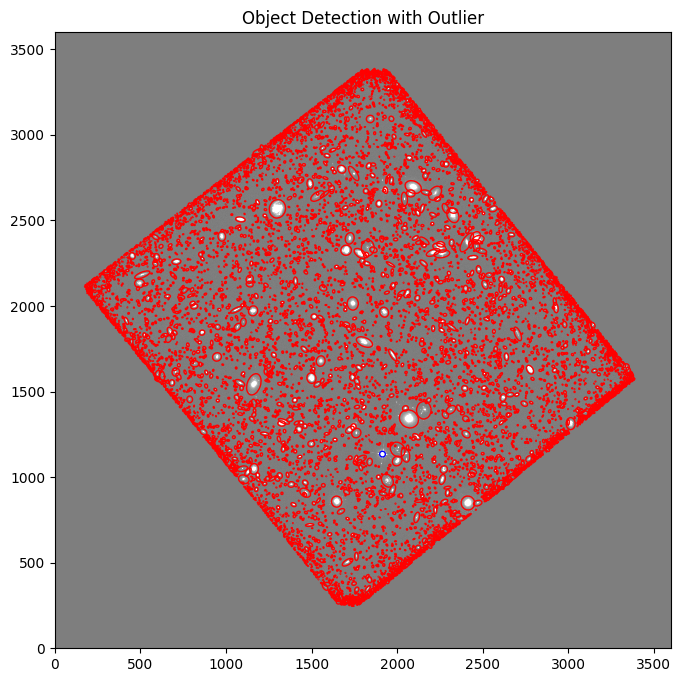

In [24]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    color = 'red' if i != np.argmax(flux) else 'blue'  # conditional statement, use blue for outlier
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6 * objects['a'][i],
                height=6 * objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi,
                facecolor='none', edgecolor=color)
    ax.add_artist(e)

plt.title('Object Detection with Outlier')
plt.savefig('ellipse_fits_with_outlier.png')


/Users/samrosales/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


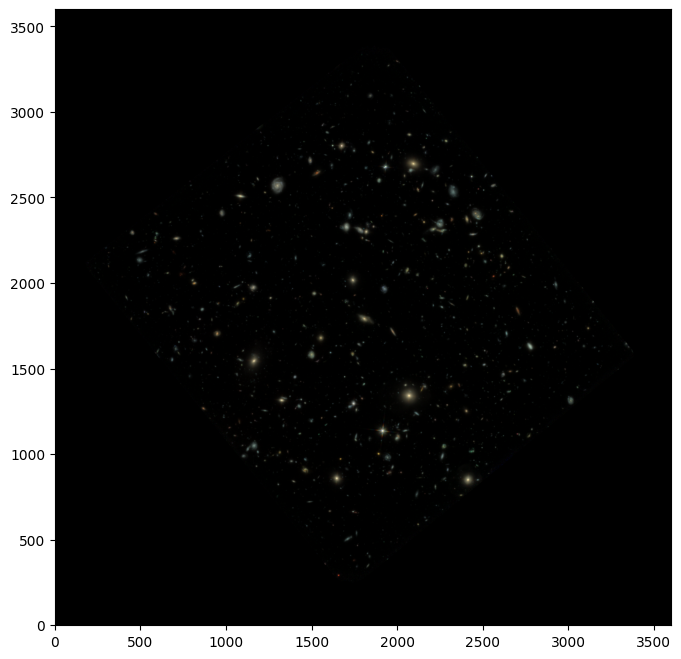

In [20]:
from astropy.visualization import make_lupton_rgb

# Load  f160w, f125w, and f105w data
image_f160w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
image_f125w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
image_f105w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

# Make a 3-color false image using RGB -> f160w, f125w, f105w
rgb_image = make_lupton_rgb(image_f160w, image_f125w, image_f105w, stretch=0.1)

# Display and save the image
plt.imshow(rgb_image, origin='lower')
plt.savefig("UDF_3color_false.png")
plt.show()